<h1 style="font-size:30px;">Weighted Box Fusion in Object Detection</h1>

This notebook will try to give a comparision between **Non-Maximum Suppression (NMS)** and **Weighted Boxes Fusion (WBF)**, and help us understand that WBF offers a more robust and effiecient approach in achieving averaged predictions across multiple detection models.

**Let's start by installing the required dependencies.**

In [ ]:
!pip install -q ultralytics ensemble-boxes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.5/627.5 kB 37.0 MB/s eta 0:00:00


In [ ]:
import os
import glob
import cv2

from zipfile import ZipFile
import requests

import numpy as np
from PIL import Image

import torch
from ultralytics import YOLO

import matplotlib.pyplot as plt

from ensemble_boxes import weighted_boxes_fusion
from torchvision.ops import nms

## 1 Download Dataset and Models

We have trained 4 models: `small(s)`, `medium(m)`, `large(l)` and `xtra large(x)` the predictions of which we want to ensemble to obtain a more generalized **"average"** predictions leading to a slighlty better evaluation metric scores.

We have provided the model checkpoints so that you can directly use them for inference.

In [ ]:
# Download and dataset.
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        with ZipFile(save_path) as z:
            z.extractall(os.path.split(save_path)[0]) # Unzip when downloaded.
            print("Done")
    except:
        print("Invalid file")

We shall now initialize and download the directories for the sample images and the models.

In [ ]:
SAMPLES_URL = f"https://www.dropbox.com/scl/fi/o2suoh5xwgzp7sy90buqt/test-samples.zip?rlkey=rr1yuy91tgli22k0d2i9y5kxa&dl=1"
SAMPLE_IMG_DIR = "test-samples"
SAMPLE_DATA_ZIP_FILE = os.path.join(os.getcwd(), f"{SAMPLE_IMG_DIR}.zip")

URL_MODEL_CKPTS = f"https://www.dropbox.com/scl/fi/6q4uhv7nj2ag2h742qmdv/yolov8-global-wheat-models.zip?rlkey=ythxu4v7kl7fhx4fgd9wp17gc&dl=1"
MODELS_DIR = "yolov8-global-wheat-models"
CKPTS_ZIP_FILE = os.path.join(os.getcwd(), f"{MODELS_DIR}.zip")

# Download if dataset does not exists.
if not os.path.exists(SAMPLE_IMG_DIR):
    download_and_unzip(SAMPLES_URL, SAMPLE_DATA_ZIP_FILE)
    os.remove(SAMPLE_DATA_ZIP_FILE)

if not os.path.exists(MODELS_DIR):
    download_and_unzip(URL_MODEL_CKPTS, CKPTS_ZIP_FILE)
    os.remove(CKPTS_ZIP_FILE)

## 2 Obtain Model Predictions

The `get_data_resolution` utility maintains a dictionary mapping from the IDs to their resolutions. The image resolutions would be required later to scale the predictions before they can be passed to the `weighted_boxes_fusion` utility.

In [ ]:
def get_data_resolution(image_dir_path, img_files):

    image_res = dict()

    for img_file in img_files:
        img_filepath = os.path.join(image_dir_path, img_file)

        image_id = img_file.strip().split(".")[0]
        image = Image.open(img_filepath)

        image_res[image_id] = image.size

    return image_res

We shall next obtain the model predictions and maintain three separate dictionaries for the predicted bounding boxes, confidence scores, and class labels with the ImageIDs as keys. The `get_predictions` function achieves this.

In [ ]:
def get_predictions(model, image_dir_path, image_filenames, conf_thres=0.25):

    preds_scores = dict()
    pred_boxes = dict()
    pred_classes = dict()

    for image_file in image_filenames:

        img_filepath = os.path.join(image_dir_path, image_file)
        image_id = image_file.strip().split(".")[0]

        pred_results = model.predict(img_filepath, conf=conf_thres)[0].boxes.cpu()

        preds_scores[image_id] = pred_results.conf.unsqueeze(dim=1).numpy()
        pred_boxes[image_id]   = pred_results.xyxy.numpy()
        pred_classes[image_id] = pred_results.cls.int().unsqueeze(dim=1).numpy()

    return preds_scores, pred_boxes, pred_classes

Recall that we have trained 4 YOLOv8 models: `small(s)`, `medium(m)`, `large(l)`, and `xtra large(x)` on the wheat data. The predictions would be ensembled and filtered out later on.

We shall instantiate each of these models first by maintaining a dictionary `model_dict`.

In [ ]:
model_dict = dict()

sample_img_files = os.listdir(SAMPLE_IMG_DIR)
data_res_dict = get_data_resolution(SAMPLE_IMG_DIR, sample_img_files)

ckpt_files = os.listdir(MODELS_DIR)

# Initilaize Model Checkpoints.
for pt_file in ckpt_files:
    model_dict["yolov8_"+pt_file.split("_")[1]] = YOLO(os.path.join(MODELS_DIR, pt_file))

We will now obtain the prediction data for each of the above instantiated model and append them to lists `pred_confs`, `pred_boxes`, and `pred_classes`.

In [ ]:
pred_confs   = []
pred_boxes   = []
pred_classes = []

for model_obj in model_dict.values():
    confs_scores, box_preds, cls_preds = get_predictions(model_obj, SAMPLE_IMG_DIR, sample_img_files)
    pred_confs.append(confs_scores)
    pred_boxes.append(box_preds)
    pred_classes.append(cls_preds)


image 1/1 /content/test-samples/cc3532ff6.jpg: 640x640 28 wheat_dets, 97.9ms
Speed: 11.8ms preprocess, 97.9ms inference, 43.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/test-samples/348a992bb.jpg: 640x640 37 wheat_dets, 61.9ms
Speed: 2.8ms preprocess, 61.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/test-samples/51b3e36ab.jpg: 640x640 25 wheat_dets, 61.9ms
Speed: 2.8ms preprocess, 61.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/test-samples/f5a1f0358.jpg: 640x640 30 wheat_dets, 61.7ms
Speed: 2.7ms preprocess, 61.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/test-samples/cc3532ff6.jpg: 640x640 27 wheat_dets, 29.6ms
Speed: 3.0ms preprocess, 29.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/test-samples/348a992bb.jpg: 640x640 38 wheat_dets, 30.2ms
Speed: 3.1ms preprocess, 30.2ms inference, 1.

## 3 Ensemble Model Predictions

### 3.1 Perform Non-Maximum-Suppression (NMS)

The `perform_non_max_suppression` utility is used to perform NMS across the model ensembles. Let us take a look at the function. It takes the following arguments:
- `pred_confs_models`: the list of predicted confidence scores across the models.

- `pred_boxes_models`: the list of predicted bounding box coordinates across the models.

- `image_ids`: the list of Image IDs.

- `IOU_THRESH`: The IoU or NMS threshold.

- `FINAL_CONF_THRESH`: The confidence threshold to further filter out the boxes after NMS.

In [ ]:
def perform_non_max_suppression(
    pred_confs_models,
    pred_boxes_models,
    image_ids,
    IOU_THRESH,
    FINAL_CONF_THRESH=None):

    nms_boxes_dict = dict()
    nms_scores_dict = dict()

    for image_id in image_ids:

        all_model_boxes   = []
        all_model_scores  = []

        for boxes, scores in zip(pred_boxes_models, pred_confs_models):
            all_model_boxes.append(torch.from_numpy(boxes[image_id]))
            all_model_scores.append(torch.from_numpy(scores[image_id]))

        # Concatenate predicted bounding boxes and conf scores across all models.
        all_model_boxes = torch.cat(all_model_boxes)
        all_model_scores = torch.cat(all_model_scores).squeeze()

        # Perform NMS on the predictions.
        # The variable 'keep' returns the indices of predictions that are retained
        # after NMS in decreasing order of conf. scores.
        keep = nms(
                boxes=all_model_boxes,
                scores=all_model_scores,
                iou_threshold=IOU_THRESH)

        # Obtain the filtered boxes and scores after NMS.
        boxes_retained = all_model_boxes[keep]
        scores_retained = all_model_scores[keep]

        # Further filter out boxes having scores > FINAL_CONF_THRESH.
        final_scores_ids = torch.where(scores_retained > FINAL_CONF_THRESH)[0]

        final_boxes = boxes_retained[final_scores_ids]
        final_scores = scores_retained[final_scores_ids]

        # Box cordinates in [xmin, ymin, width, height] format.
        final_boxes = final_boxes.int()
        final_boxes[:,2:] = final_boxes[:,2:] - final_boxes[:, :2]

        # Append final_boxes and final_scores in dictionaries mapped with IMAGE_IDs.
        nms_boxes_dict[image_id] = final_boxes.tolist()
        nms_scores_dict[image_id] = torch.unsqueeze(torch.round(final_scores, decimals=5), dim=-1).tolist()


    return nms_boxes_dict, nms_scores_dict

The final predicted boxes and scores are stored in `boxes_dict_nms` and `scores_dict_nms`, respectively.

In [ ]:
image_ids = list(data_res_dict.keys())

boxes_dict_nms, scores_dict_nms = perform_non_max_suppression(
                                    pred_confs,
                                    pred_boxes,
                                    image_ids,
                                    IOU_THRESH=0.50,
                                    FINAL_CONF_THRESH=0.28)

### 3.2 Weighted Boxes Fusion (WBF) for Ensembling Multi-Model Predictions

We will be using the `ensemble-boxes` package and use the `weighted_boxes_fusion` utility function to compute the fused scores. The implementation can be found in thier [repository](https://github.com/ZFTurbo/Weighted-Boxes-Fusion/tree/master).

The `weighted_boxes_fusion` accepts the box coordinates across the different models as list in $[x_{min}, y_{min}, x_{max}, y_{max}]$ in **normalized** format.

The `perform_weighted_boxes_fusion` function accepts the confidence scores, bounding box coordinates, and class labels obtained in the previous section and returns the fused box cordinates (in `[xmin, ymin, width, height]` format) and confidence scores as dictionaries with **ImageIds** as keys.

Similar to the `perform_non_max_suppression` utility, the `perform_weighted_boxes_fusion` function takes the following arguments:

- `pred_confs_models`: the list of predicted confidence scores across the models.

- `pred_boxes_models`: the list of predicted bounding box coordinates across the models.

- `resolution_dict`: a dictionary mapping from Image IDs to its corresponding shape.

- `IOU_THRESH`: The IoU threshold to filter out the predictions.

- `CONF_THRESH`: To exclude boxes with confidences lower than this threshold.

- `FINAL_CONF_THRESH`: The confidence threshold to further filter out the boxes after NMS.

In [ ]:
def perform_weighted_boxes_fusion(
        pred_confs_models,
        pred_boxes_models,
        pred_classes_models,
        resolution_dict,
        IOU_THRESH=0.5,
        CONF_THRESH=None,
        FINAL_CONF_THRESH=1e-3):

    wbf_boxes_dict = dict()
    wbf_scores_dict = dict()

    for image_id, res in resolution_dict.items():

        res_array = np.array([res[1], res[0], res[1], res[0]]) # [W, H, W, H]

        all_model_boxes   = []
        all_model_scores  = []
        all_model_classes = []

        for boxes, scores, classes in zip(pred_boxes_models, pred_confs_models, pred_classes_models):

            # Normalize [xmin, ymin, xmax, ymax] in normalized form.
            pred_boxes_norm = (boxes[image_id] / res_array).clip(min=0., max=1.)
            scores_model = scores[image_id]
            classes_model = classes[image_id]

            all_model_boxes.append(pred_boxes_norm)
            all_model_scores.append(scores_model)
            all_model_classes.append(classes_model)

        # Perform weighted box fusion.
        boxes, scores, labels = weighted_boxes_fusion(
                                        all_model_boxes,
                                        all_model_scores,
                                        all_model_classes,
                                        weights=None,
                                        iou_thr=IOU_THRESH,
                                        skip_box_thr=CONF_THRESH)


        # Further filter out boxes having scores > FINAL_CONF_THRESH.
        final_scores_ids = np.where(scores > FINAL_CONF_THRESH)[0]

        final_boxes = boxes[final_scores_ids]
        final_scores = scores[final_scores_ids]

        # Box cordinates in [xmin, ymin, xmax, ymax] in de-normalized form.
        final_boxes = (final_boxes*res_array).clip(min=[0.,0.,0.,0.],
                                                   max=[res[1]-1, res[0]-1, res[1]-1, res[0]-1])

        final_boxes = final_boxes.astype("int")

        # Box cordinates in [xmin, ymin, width, height] in de-normalized form.
        final_boxes[:,2:] = final_boxes[:,2:] - final_boxes[:, :2]

        wbf_boxes_dict[image_id] = final_boxes.tolist()
        wbf_scores_dict[image_id] = np.expand_dims(np.round(final_scores, 5), axis=-1).tolist()


    return wbf_boxes_dict, wbf_scores_dict

We will use the scores, box coordinates and predicted classes obtained in the previous section to get the fused boxes and scores.

In [ ]:
boxes_dict_wbf, scores_dict_wbf = perform_weighted_boxes_fusion(
                                    pred_confs,
                                    pred_boxes,
                                    pred_classes,
                                    data_res_dict,
                                    IOU_THRESH=0.50,
                                    CONF_THRESH=0.32,
                                    FINAL_CONF_THRESH=0.28)

## 4 Visualize Predictions

The `draw_bbox_conf` utility plots the bounding boxes and the confidence scores on the corresponding image.

In [ ]:
def draw_bbox_conf(image, boxes, scores, class_name, color=(255, 0, 0), thickness=-1):

    overlay = image.copy()

    font_size = 0.25 + 0.07 * min(overlay.shape[:2]) / 100
    font_size = max(font_size, 0.5)
    font_size = min(font_size, 0.8)
    text_offset = 7

    for box, score in zip(boxes, scores):
        xmin = box[0]
        ymin = box[1]
        xmax = box[0]+box[2]
        ymax = box[1]+box[3]

        overlay = cv2.rectangle(overlay,
                                (xmin, ymin),
                                (xmax, ymax),
                                color,
                                thickness)

        display_text = f"{class_name}: {score[0]:.2f}"

        (text_width, text_height), _ = cv2.getTextSize(display_text,
                                                       cv2.FONT_HERSHEY_SIMPLEX,
                                                       font_size, 2)

        cv2.rectangle(overlay,
                      (xmin, ymin),
                      (xmin + text_width + text_offset,
                       ymin - text_height - int(15 * font_size)),
                      color, thickness=-1)


        overlay = cv2.putText(
                    overlay,
                    display_text,
                    (xmin + text_offset, ymin - int(10 * font_size)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_size,
                    (255, 255, 255),
                    2, lineType=cv2.LINE_AA,
                )

    return cv2.addWeighted(overlay, 0.75, image, 0.25, 0)

The `visualize_boxes` iterates over the image files, the predicted bounding boxes and their corresponding confidence scores and calls the `draw_bbox_conf` to plot them.

In [ ]:
def visualize_boxes(root_dir, img_files, boxes_dict, scores_dict, plt_title):

    fig = plt.figure(figsize=(10, 25), layout="constrained")

    for i,(img_file, box_data, confs) in enumerate(zip(img_files, boxes_dict.values(), scores_dict.values())):
        filename = os.path.join(root_dir, img_file)
        image = cv2.imread(filename)
        image =  draw_bbox_conf(image, box_data, confs, class_name="wheat_head", color=(0, 0, 255), thickness=3)

        ax = plt.subplot(5, 2, i+1)
        plt.suptitle(f"{plt_title}", fontweight="bold")
        plt.imshow(image[..., ::-1])
        plt.axis("off")


plt.show()

The following subplots show the inference results for NMS.

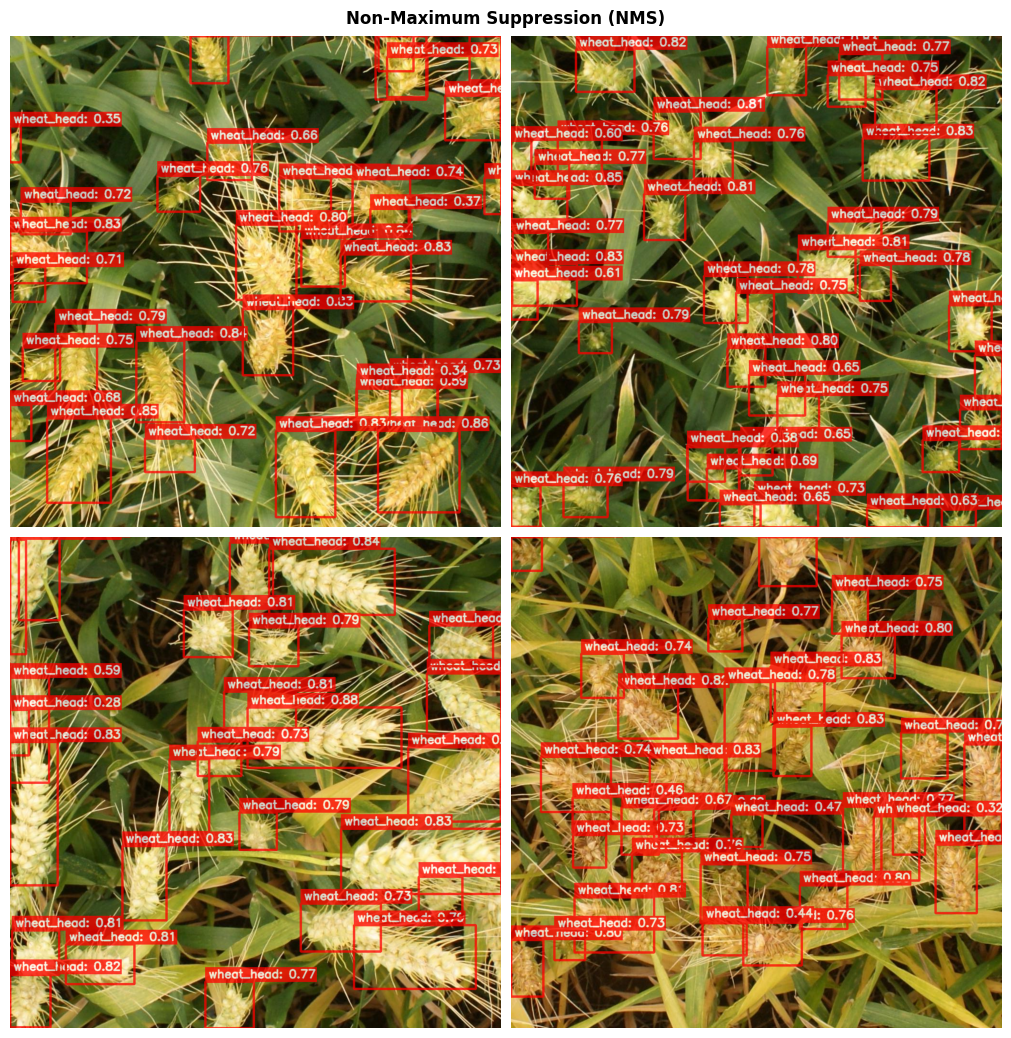

In [ ]:
visualize_boxes(
    SAMPLE_IMG_DIR,
    sample_img_files,
    boxes_dict_nms,
    scores_dict_nms,
    "Non-Maximum Suppression (NMS)")

The following subplots show the inference results for WBF.

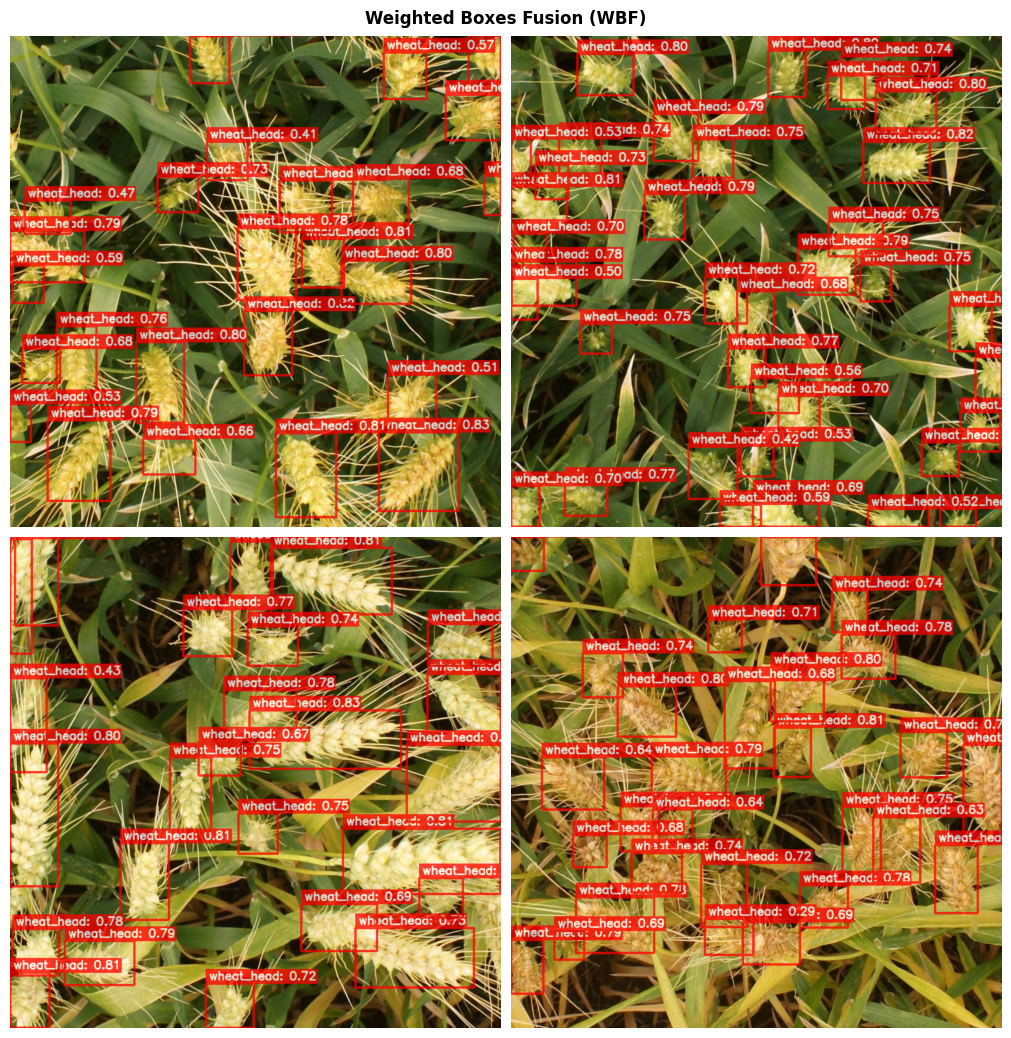

In [ ]:
visualize_boxes(SAMPLE_IMG_DIR,
                sample_img_files,
                boxes_dict_wbf,
                scores_dict_wbf,
                "Weighted Boxes Fusion (WBF)")